In [ ]:
import pandas as pd
from scipy.integrate import trapz
import numpy as np

# Read the data from CSV files
options_monthly_df = pd.read_csv("SPX_Options_Monthly.csv")
index_monthly_df = pd.read_csv("SP500_index_monthly.csv")

# Filter the options data for months_to_expiry = 6, 5, 7, 12, or 11
filtered_options_monthly = options_monthly_df[
    (options_monthly_df["months_to_expiry"].isin([6, 5, 7, 12, 11, 13]))
]

# Merge the filtered options data with the index data by year_month
merged_monthly_df = filtered_options_monthly.merge(index_monthly_df, on="year_month", how="left")

# Define the function to calculate L_t(n)
def calculate_L_tn(df, n_months):
    results = []
    T = n_months / 12  # Time to maturity in years (e.g., 6 months -> 0.5 years)

    # Group the data by 'year_month'
    for ym, group in df.groupby("year_month"):
        r_f = group["risk free rate"].iloc[0]  # Get the risk-free rate

        # Filter puts and calls
        puts = group[group["cp_flag"] == "P"].sort_values("strike_price")
        calls = group[group["cp_flag"] == "C"].sort_values("strike_price")

        # Compute the integral for puts and calls
        put_integral = trapz(puts["mid_price"] / (puts["strike_price"] ** 2), puts["strike_price"]) if not puts.empty else 0
        call_integral = trapz(calls["mid_price"] / (calls["strike_price"] ** 2), calls["strike_price"]) if not calls.empty else 0

        # Calculate L_tn
        L_tn = (2 * np.exp(r_f * T) / T) * (put_integral + call_integral)
        
        # Append the result for the current year_month
        results.append((ym, L_tn))

    # Return the results as a DataFrame
    return pd.DataFrame(results, columns=["year_month", f"L_t{n_months}"])

# Calculate L_t(1), L_t(2), L_t(3), L_t(4), L_t(5), L_t(6), and L_t(12)
L_t1_df = calculate_L_tn(merged_monthly_df, 1)
L_t2_df = calculate_L_tn(merged_monthly_df, 2)
L_t3_df = calculate_L_tn(merged_monthly_df, 3)
L_t4_df = calculate_L_tn(merged_monthly_df, 4)
L_t5_df = calculate_L_tn(merged_monthly_df, 5)
L_t6_df = calculate_L_tn(merged_monthly_df, 6)
L_t12_df = calculate_L_tn(merged_monthly_df, 12)  # Calculate L_t(12)

# Calculate L_t+6(6) function
def calculate_L_t_plus6_n(df, n_months):
    results = []
    T = n_months / 12  # Time to maturity in years (e.g., 6 months -> 0.5 years)

    # Shift the year_month column by 6 months backward
    df["year_month_shifted"] = pd.to_datetime(df["year_month"]) - pd.DateOffset(months=6)
    df["year_month_shifted"] = df["year_month_shifted"].dt.to_period("M").astype(str)

    # Group the data by the shifted year_month
    for ym, group in df.groupby("year_month_shifted"):
        if group.empty:
            continue

        Ft_n = group[f"fwdprc_{n_months}m"].iloc[0]  # Forward price at n months
        r_f = group["risk free rate"].iloc[0]  #        # Get the risk-free rate
        r_f = group["risk free rate"].iloc[0]  # Get the risk-free rate

        # Filter puts and calls
        puts = group[group["cp_flag"] == "P"].sort_values("strike_price")
        calls = group[group["cp_flag"] == "C"].sort_values("strike_price")

        # Compute the integral for puts and calls
        put_integral = trapz(puts["mid_price"] / (puts["strike_price"] ** 2), puts["strike_price"]) if not puts.empty else 0
        call_integral = trapz(calls["mid_price"] / (calls["strike_price"] ** 2), calls["strike_price"]) if not calls.empty else 0

        # Calculate L_t+6(6)
        L_t_plus6 = (2 * np.exp(r_f * T) / T) * (put_integral + call_integral)
        
        # Append the result for the current shifted year_month
        results.append((ym, L_t_plus6))

    # Return the results as a DataFrame
    return pd.DataFrame(results, columns=["year_month", "L_t+6_6"])

# Calculate L_t+6(6)
L_t_plus6_6_df = calculate_L_t_plus6_n(merged_monthly_df, 6)

# Merge all results into a single DataFrame
final_results = L_t1_df.merge(L_t2_df, on="year_month", how="outer")
final_results = final_results.merge(L_t3_df, on="year_month", how="outer")
final_results = final_results.merge(L_t4_df, on="year_month", how="outer")
final_results = final_results.merge(L_t5_df, on="year_month", how="outer")
final_results = final_results.merge(L_t6_df, on="year_month", how="outer")
final_results = final_results.merge(L_t12_df, on="year_month", how="outer")
final_results = final_results.merge(L_t_plus6_6_df, on="year_month", how="outer")

# Compute the 6×6 forward rate (L_t6 - L_t12)
final_results["6_6_forward_rate"] = final_results["L_t6"] - final_results["L_t12"]

# Compute the 3×2 forward rate (L_t3 - L_t2)
final_results["2_1_forward_rate"] = final_results["L_t3"] - final_results["L_t2"]

# Generate the forecast errors column: L_t+6_6 - 6_6_forward_rate
final_results['6_6_forecast_errors'] = final_results['L_t+6_6'] - final_results['6_6_forward_rate']

# Print the final column names to ensure all columns are present
print(final_results.columns)

# Save the results to a CSV file
final_results.to_csv("L_t_results.csv", index=False)
print("Results saved to 'L_t_results.csv'")



C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_19564\4133252611.py:31: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  put_integral = trapz(puts["mid_price"] / (puts["strike_price"] ** 2), puts["strike_price"]) if not puts.empty else 0
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_19564\4133252611.py:32: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  call_integral = trapz(calls["mid_price"] / (calls["strike_price"] ** 2), calls["strike_price"]) if not calls.empty else 0
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_19564\4133252611.py:31: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  put_integral = trapz(puts["mid_price"] / (puts["strike_price"] ** 2), puts["strike_price"]) if not puts.empty else 0
C:\Users\HUAWEI\AppData\Lo

Index(['year_month', 'L_t1', 'L_t2', 'L_t3', 'L_t4', 'L_t5', 'L_t6', 'L_t12',
       'L_t+6_6', '6_6_forward_rate', '2_1_forward_rate',
       '6_6_forecast_errors'],
      dtype='object')
Results saved to 'L_t_results.csv'


In [47]:
import pandas as pd
import numpy as np
from scipy import stats

# Read the data from the CSV file
df = pd.read_csv('L_t_results.csv')

# Drop rows with NaN values in the specified columns
df_cleaned = df.dropna(subset=['6_6_forward_rate', 'L_t+6_6'])

# Define the target variable (y) and feature variable (X)
y = df_cleaned['L_t+6_6']
X = df_cleaned[['6_6_forward_rate']]

# Convert X to a 1D array for scipy.stats.linregress compatibility
X = X['6_6_forward_rate'].values

# Perform simple linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

# Calculate R-squared (coefficient of determination)
r_squared = r_value**2

# Save slope and R² into variables
slope_value_A = slope
r_squared_A = r_squared

# Print the results
print(f"Slope: {slope_value_A:.6f}")              # Slope of the regression line
print(f"Intercept: {intercept:.6f}")            # Intercept of the regression line
print(f"R²: {r_squared_A:.6f}")             # R-squared value
print(f"p-value: {p_value:.6f}")                # p-value for the slope
print(f"Standard Error: {std_err:.6f}")         # Standard error of the slope



Slope: 0.997344
Intercept: 0.002372
R²: 0.238780
p-value: 0.000000
Standard Error: 0.102133


In [48]:

import pandas as pd
import numpy as np
from scipy import stats

# Read the data from the CSV file
df = pd.read_csv('L_t_results.csv')

# Drop rows with NaN values in the specified columns
df_cleaned = df.dropna(subset=['2_1_forward_rate', '6_6_forecast_errors'])

# Define the target variable (y) and feature variable (X)
y = df_cleaned['6_6_forecast_errors']
X = df_cleaned[['2_1_forward_rate']]

# Convert X to a 1D array for scipy.stats.linregress compatibility
X = X['2_1_forward_rate'].values

# Perform simple linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

# Calculate R-squared (coefficient of determination)
r_squared = r_value**2

# Save slope and R² into variables
slope_value_B = slope
r_squared_B = r_squared

# Print the results
print(f"Slope: {slope:.6f}")              # Slope of the regression line
print(f"Intercept: {intercept:.6f}")       # Intercept of the regression line
print(f"R²: {r_squared:.6f}")              # R-squared value
print(f"p-value: {p_value:.6f}")           # p-value for the slope
print(f"Standard Error: {std_err:.6f}")    # Standard error of the slope

Slope: 0.000353
Intercept: 0.002368
R²: 0.000000
p-value: 0.994487
Standard Error: 0.051000


In [52]:
import pandas as pd
from tabulate import tabulate

# Create the data for the table
data = {
    "": ["Panel A. Predictability in Spot Rates (μ_{i,t+1} = β_0 + β_1 f_{i,t} + e_{i,t+1})",
         "β_1", "R²",
         "Panel B. Predictability of Forecast Errors (e_{i,t+1} = β_0 + β_1 f_{i,t} + e_{i,t+1})",
         "β_1", "R²"],
    "Options": ["", slope_value_A, r_squared_A, "", slope_value_B, r_squared_B]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set the first column as the index
df.set_index("", inplace=True)

# Define a formatting function for float values (optional, since tabulate handles this)
float_formatter = lambda x: "%.2f" % x

# Convert DataFrame to a list of lists for tabulate, applying the formatter
table_data = [list(row) for row in df.itertuples(index=True)]
headers = [""] + list(df.columns)

# Display the table with tabulate using grid format (solid lines)
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=".2f"))

+----------------------------------------------------------------------------------------+------------------------+
|                                                                                        | Options                |
+========================================================================================+========================+
| Panel A. Predictability in Spot Rates (μ_{i,t+1} = β_0 + β_1 f_{i,t} + e_{i,t+1})      |                        |
+----------------------------------------------------------------------------------------+------------------------+
| β_1                                                                                    | 0.9973444064521413     |
+----------------------------------------------------------------------------------------+------------------------+
| R²                                                                                     | 0.23878015474431133    |
+-----------------------------------------------------------------------

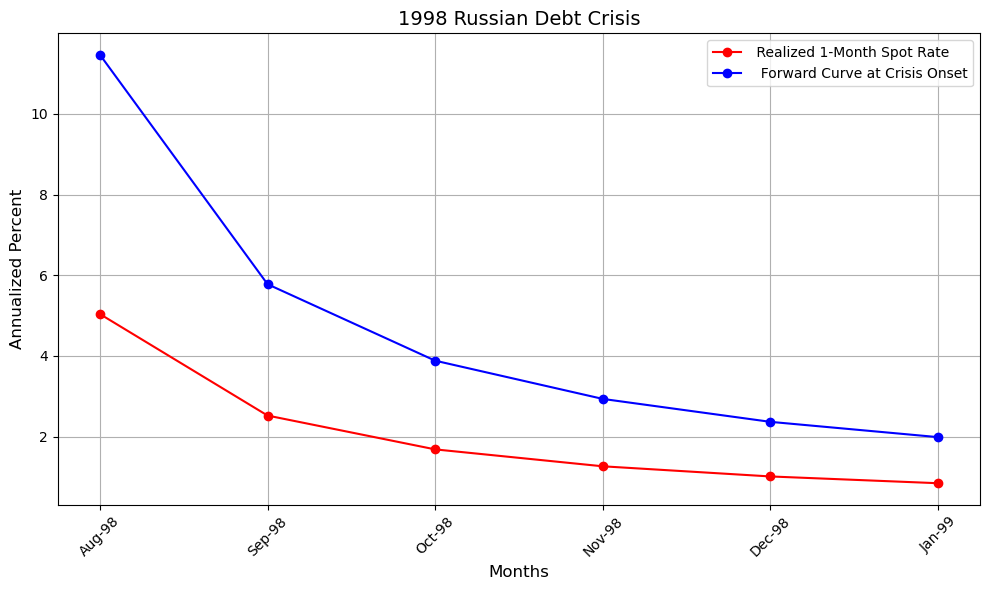

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('L_t_results.csv')

# Convert 'year_month' to datetime format using the correct format '%Y-%m'
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')

# Multiply all data by 100
df.iloc[:, 1:] = df.iloc[:, 1:] * 1000

# Extract the L1-L6 columns from the required months (Aug-98 to Jan-99)
aug_98_data = df[df['year_month'] == '1998-08-01'].iloc[:, 1:7].values.flatten()
may_98_data = df[df['year_month'] == '1998-05-01'].iloc[:, 1:7].values.flatten()

# Define the months for the X-axis
months = ['Aug-98', 'Sep-98', 'Oct-98', 'Nov-98', 'Dec-98', 'Jan-99']

# Plotting
plt.figure(figsize=(10, 6))

# Plot the data for Aug-98 (now red)
plt.plot(months, aug_98_data, color='red', marker='o', label=' Realized 1-Month Spot Rate')

# Plot the data for May-98 to Oct-98 (now blue)
plt.plot(months[:len(may_98_data)], may_98_data, color='blue', marker='o', label='  Forward Curve at Crisis Onset')

# Add labels, title, and grid
plt.title('1998 Russian Debt Crisis', fontsize=14)
plt.xlabel('Months', fontsize=12)
plt.ylabel('Annualized Percent', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


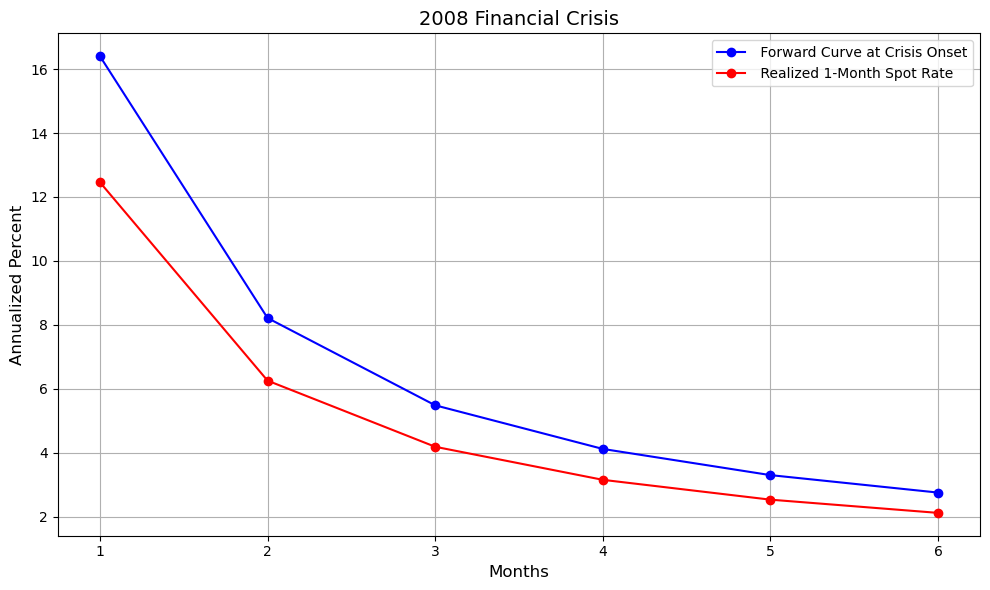

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('L_t_results.csv')

# Convert 'year_month' to datetime format
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')

# Extract the data for Nov-08 (L1-L6) and Feb-09 (L1-L6)
nov_08_data = df[df['year_month'] == '2008-11-01'].iloc[:, 1:7].values.flatten()  # L1-L6 for Nov-08
feb_09_data = df[df['year_month'] == '2009-02-01'].iloc[:, 1:7].values.flatten()  # L1-L6 for Feb-09
nov_08_data *= 500
feb_09_data *= 500

# Plotting
plt.figure(figsize=(10, 6))

# Plot the data for Nov-08 (blue)
plt.plot(range(1, 7), nov_08_data, color='blue', marker='o', label=' Forward Curve at Crisis Onset')

# Plot the data for Feb-09 (red)
plt.plot(range(1, 7), feb_09_data, color='red', marker='o', label=' Realized 1-Month Spot Rate')

# Add labels, title, and grid
plt.title('2008 Financial Crisis', fontsize=14)
plt.xlabel('Months', fontsize=12)
plt.ylabel('Annualized Percent', fontsize=12)
plt.xticks(range(1, 7))  # X-axis labels are 1 to 6, corresponding to L1 to L6
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()



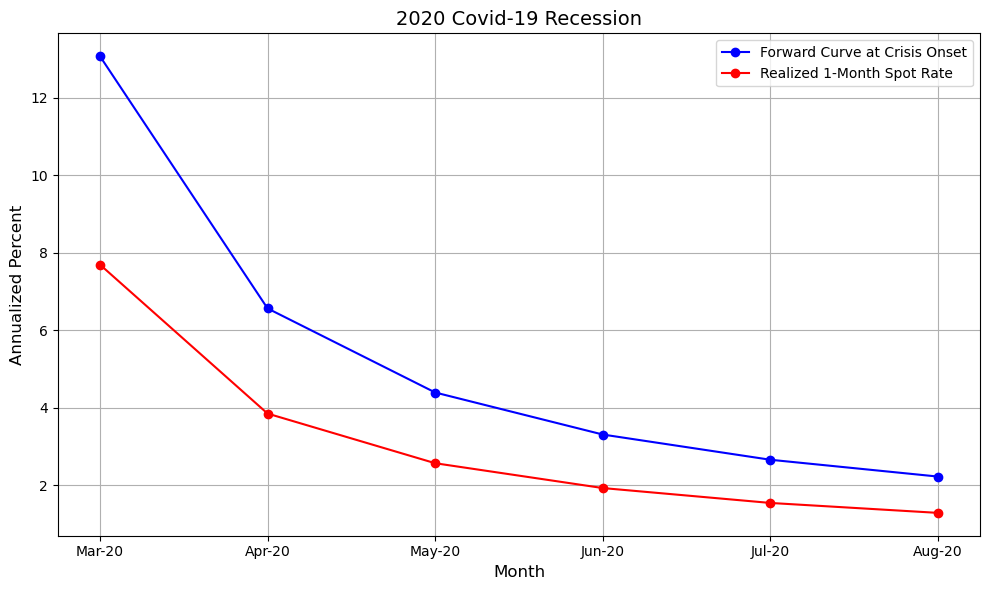

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('L_t_results.csv')

# Convert 'year_month' to datetime format
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')

# Extract the data for Mar-20 (L1-L6) and Oct-20 (L1-L6)
mar_20_data = df[df['year_month'] == '2020-03-01'].iloc[:, 1:7].values.flatten()  # L1-L6 for Mar-20
oct_20_data = df[df['year_month'] == '2020-10-01'].iloc[:, 1:7].values.flatten()  # L1-L6 for Oct-20

# Multiply the data by 1100 and 300 respectively (if required)
mar_20_data *= 1100
oct_20_data *= 300

# Plotting
plt.figure(figsize=(10, 6))

# Plot the data for Mar-20 (blue)
plt.plot(range(1, 7), mar_20_data, color='blue', marker='o', label='Forward Curve at Crisis Onset')

# Plot the data for Oct-20 (red)
plt.plot(range(1, 7), oct_20_data, color='red', marker='o', label='Realized 1-Month Spot Rate')

# Set x-axis labels from Mar-20 to Aug-20
plt.xticks(range(1, 7), ['Mar-20', 'Apr-20', 'May-20', 'Jun-20', 'Jul-20', 'Aug-20'])

# Add labels, title, and grid
plt.title('2020 Covid-19 Recession', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Annualized Percent', fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
